In [84]:
!sudo apt-get update
!sudo apt-get -y install enchant-2
!pip install ftfy regex tqdm pyenchant
!pip install git+https://github.com/openai/CLIP.git
import clip
import json
import numpy as np
import torch
import torchtext
from PIL import Image
from IPython.display import Image as IM
from IPython.display import display
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import enchant
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device=device)

Hit:1 http://packages.cloud.google.com/apt gcsfuse-focal InRelease
Hit:2 https://packages.cloud.google.com/apt cloud-sdk InRelease                
Hit:3 https://packages.cloud.google.com/apt google-fast-socket InRelease       
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]      
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease   
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Fetched 337 kB in 1s (272 kB/s)  
Reading package lists... Done
W: http://packages.cloud.google.com/apt/dists/gcsfuse-focal/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: https://packages.cloud.google.com/apt/dists/google-fast-socket/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.

In [ ]:
display(IM(filename='/kaggle/input/vizwiz/data/Images/VizWiz_train_000000000001.jpg'))

In [2]:
data = None

with open('/kaggle/input/vizwiz/data/Annotations/train.json') as f:
  data = json.load(f)

In [3]:
with open('/kaggle/input/vizwiz/data/Annotations/val.json') as f:
  val_data = json.load(f)

In [4]:
answer_freq = {}
for entry in data:
    for ans in entry['answers']:
        if ans['answer'] in answer_freq.keys():
            answer_freq[ans['answer']]+=1
        else:
            answer_freq[ans['answer']] = 1

In [5]:
len(answer_freq.keys())

40271

In [6]:
def get_answers_from_dict(answers_dict):
    answers = [entry['answer'] for entry in answers_dict]
    return answers

In [7]:
def get_answer_clip(model, preprocess, img_path, answers):
    global device
    image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
    text = clip.tokenize(answers).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)

        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    return np.argmax(probs)

In [8]:
def get_lowest_levenshtein(answers, candidates):
    scores = []
    for candidate in candidates:
        score = 0
        for answer in answers:
            score+=enchant.utils.levenshtein(candidate, answer)
        scores.append(score)
        
    return np.argmin(scores)

In [9]:
def get_most_common(answers, all_answers):
    global answer_frq
    idx = None
    freq = -1
    draws = []
    for i, answer in enumerate(answers):
        if answer in answer_freq.keys():
            fq = answer_freq[answer]
        else:
            fq = 0
        if fq>freq:
            idx = i
            freq = fq
            draws = [(answer,i)]
        elif fq==freq:
            draws.append((answer,i))
            
    if len(draws)>1:
        candids = [a[0] for a in draws]
        idx = draws[get_lowest_levenshtein(all_answers, candids)][1]
    return idx

In [56]:
def get_answer_most_common(answers, model=None, preprocess=None, img_path=None, clip=False, freq=False):
    common_idx = None
    count = -1
    draws = []
    for idx,answer in enumerate(answers):
        c = answers.count(answer)
        if c > count:
            count = c
            common_idx = idx
            draws = [(answer, idx)]
        elif c==count:
            draws.append((answer, idx))
            
    if len(draws)>1:
        tmp = [a[0] for a in draws]
        if clip:
            common_idx = draws[get_answer_clip(model, preprocess, img_path, tmp)][1]
        elif freq:
            common_idx = draws[get_most_common(tmp, answers)][1]
#         common_idx = draws[get_lowest_levenshtein(answers, tmp)][1]
    return common_idx

In [58]:
def create_df(data, selection=2):
    df = []

    for i,entry in enumerate(data):
        if entry['answerable']==0:
            answer = 'unanswerable'
        else:
            if selection==1:
                idx = get_answer_clip(model, preprocess, '/kaggle/input/vizwiz/data/Images/'+entry['image'], get_answers_from_dict(entry['answers']))
            elif selection==2:
                idx = get_answer_most_common(get_answers_from_dict(entry['answers']))
            elif selection==3:
                idx = get_answer_most_common(get_answers_from_dict(entry['answers']), model=model, preprocess=preprocess, img_path='/kaggle/input/vizwiz/data/Images/'+entry['image'], clip=True)
            elif selection==4:
                idx = get_answer_most_common(get_answers_from_dict(entry['answers']), freq=True)    
        
            answer = entry['answers'][idx]['answer']
            
        df.append([entry['image'], entry['answerable'], entry['question'], entry['answer_type'], answer])
        if i%1000==0:
            print('Checkpoint at: ' + str(i))

    return np.array(df)

In [59]:
selection = 4
df = create_df(data, selection)

Checkpoint at: 0
Checkpoint at: 1000
Checkpoint at: 2000
Checkpoint at: 3000
Checkpoint at: 4000
Checkpoint at: 5000
Checkpoint at: 6000
Checkpoint at: 7000
Checkpoint at: 8000
Checkpoint at: 9000
Checkpoint at: 10000
Checkpoint at: 11000
Checkpoint at: 12000
Checkpoint at: 13000
Checkpoint at: 14000
Checkpoint at: 15000
Checkpoint at: 16000
Checkpoint at: 17000
Checkpoint at: 18000
Checkpoint at: 19000


In [33]:
with open('/kaggle/working/df'+str(selection)+'.npy', 'wb') as f:
    np.save(f,df)

In [ ]:
with open('/kaggle/input/dfasdasd/df3.npy', 'rb') as f: 
    df = np.load(f)

In [13]:
df.shape

(20000, 5)

In [60]:
answers = np.array([entry[4] for entry in df])

In [61]:
answer_types = np.array([entry[3] for entry in df])

In [62]:
selection = 4
val_df = create_df(val_data, selection)

Checkpoint at: 0
Checkpoint at: 1000
Checkpoint at: 2000
Checkpoint at: 3000


In [ ]:
with open('/kaggle/working/val_df'+str(selection)+'.npy', 'wb') as f:
    np.save(f,val_df)

In [ ]:
with open('/kaggle/input/dfasdasd/val_df.npy', 'rb') as f: 
    val_df = np.load(f)

In [63]:
val_answers = np.array([entry[4] for entry in val_df])

In [64]:
val_answer_types = np.array([entry[3] for entry in val_df])

In [19]:
def create_samples(model, preprocess, img_path, question, rotate=True):
    global device
    samples = []
    img = Image.open(img_path)
    
    encoded_q = model.encode_text(clip.tokenize(question).to(device))
    encoded_img = model.encode_image(preprocess(img).unsqueeze(0).to(device))
#     samples.append(torch.hstack([encoded_img, encoded_q]))
    if not rotate:
        return torch.hstack([encoded_img, encoded_q])

    # Rotate Image By 90 Degree
    rotated_image1 = img.rotate(90)
    encoded_img_r90 = model.encode_image(preprocess(rotated_image1).unsqueeze(0).to(device))
#     samples.append(torch.hstack([encoded_img, encoded_q]))

    # Rotate Image By 180 Degree
    rotated_image2 = img.rotate(-90)
    encoded_img_rn90 = model.encode_image(preprocess(rotated_image2).unsqueeze(0).to(device))
#     samples.append(torch.hstack([encoded_img, encoded_q]))

#     # Rotate Image By 270 Degree
#     rotated_image3 = img.rotate(270)
#     encoded_img3 = model.encode_image(preprocess(rotated_image3).unsqueeze(0).to(device))
#     samples.append(torch.hstack([encoded_img, encoded_q]))
        
    average = (encoded_img + encoded_img_r90 + encoded_img_rn90) / 3
    return torch.hstack([average, encoded_q])
        

In [20]:
def create_X(df, rotate=False):
    global device
    X = []

    with torch.no_grad():
      for i, entry in enumerate(df):
        X.extend(create_samples(model, preprocess, '/kaggle/input/vizwiz/data/Images/'+entry[0], entry[2], rotate))
        if i%1000==0:
            print('Checkpoint at: ' + str(i))

    return torch.vstack(X)

In [ ]:
X = create_X(df, rotate=True)

In [ ]:
torch.save(X,'/kaggle/working/X.pt')

In [21]:
X = torch.load('/kaggle/input/dfasdasd/X (1).pt', map_location=device)

In [ ]:
X_val = create_X(val_df)

In [ ]:
torch.save(X_val,'/kaggle/working/X_val.pt')

In [22]:
X_val = torch.load('/kaggle/input/dfasdasd/X_val (1).pt')

In [65]:
lb_types = preprocessing.LabelBinarizer()

encoded_answer_types = lb_types.fit_transform(answer_types)

print(encoded_answer_types[10])

[0 1 0 0]


In [66]:
lb_types.classes_

array(['number', 'other', 'unanswerable', 'yes/no'], dtype='<U12')

In [67]:
lb_answers = preprocessing.LabelBinarizer()

encoded_answers = lb_answers.fit_transform(answers)

print(encoded_answers[10])

[0 0 0 ... 0 0 0]


In [68]:
lb_answers.classes_.shape

(4856,)

In [69]:
y = [(a_type, a) for a_type, a in zip(encoded_answer_types, encoded_answers)]

In [70]:
val_encoded_answer_types = lb_types.transform(val_answer_types)
val_encoded_answers = lb_answers.transform(val_answers)
y_val = [(a_type, a) for a_type, a in zip(val_encoded_answer_types, val_encoded_answers)]

# This is a problem :)

In [71]:
c = 0
for ans in val_encoded_answers:
    c += ans.sum()
print(c)
print(len(val_encoded_answers))

2605
3173


In [72]:
c = 0
for ans in val_encoded_answer_types:
    c += ans.sum()
print(c)
print(len(val_encoded_answer_types))

3173
3173


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, stratify=y)

In [73]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset class
class VQADataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.atypes = []
        self.answers = []
        for atype, ans in labels:
          self.atypes.append(atype)
          self.answers.append(ans)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = torch.Tensor(self.data[index])
        at, a = torch.Tensor(self.atypes[index]), torch.Tensor(self.answers[index])

        return x, at, a

In [74]:
train_set = DataLoader(VQADataset(X, y), batch_size=32)
# test_set = DataLoader(VQADataset(X_test, y_test), batch_size=512)
val_set = DataLoader(VQADataset(X_val, y_val), batch_size=32)

In [100]:
class VQA_Network(nn.Module):
    def __init__(self, num_classes, vocab_size, hidden_dim, embedding_dim):
        super(VQA_Network, self).__init__()

        self.fc = nn.Linear(embedding_dim, hidden_dim)
        self.fc2_answers = nn.Linear(hidden_dim, vocab_size)

        self.fc2_aux = nn.Linear(hidden_dim, num_classes)
        self.fc3_aux = nn.Linear(num_classes, vocab_size)

        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout()
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.to(dtype=torch.float32)
        x = self.fc(x)
        x = self.norm(x)
        x = self.dropout(x)

        atype = self.fc2_aux(x)
        aux = self.fc3_aux(atype)
        aux = self.relu(aux)

        answers = self.fc2_answers(x)

        answers = answers * self.sigmoid(aux)

        return answers, atype


In [101]:
num_classes = 4
vocab_size = 4856
hidden_dim = 512
embedding_dim = 1024
train_accs_a = []
val_accs_a = []
train_accs_at = []
val_accs_at = []

num_epochs = 200

# Instantiate the model
model = VQA_Network(num_classes, vocab_size, hidden_dim, embedding_dim).to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss_a = 0.0
    running_loss_at = 0.0
    acc_a = 0
    acc_at = 0
    val_running_loss_a = 0.0
    val_running_loss_at = 0.0
    val_acc_a = 0
    val_acc_at = 0

    for xs, atypeset, answerset in train_set:
        # Move data to the device
        xs = xs.to(device)
        atypeset = atypeset.to(device)
        answerset = answerset.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        answers, atypes = model(xs)
        # print(xs.size())
        # print(labelset.size())
        # Compute loss
        answer_loss = criterion(answers, answerset)
        atype_loss = criterion(atypes, atypeset)

        # Compute loss
        loss = answer_loss + atype_loss

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Update running loss
        running_loss_a += answer_loss.item()
        running_loss_at += atype_loss.item()
        acc_at += (torch.argmax(atypes, 1) == torch.argmax(atypeset, 1)).float().sum()
        acc_a += (torch.argmax(answers, 1) == torch.argmax(answerset, 1)).float().sum()

    acc_a = acc_a / len(y)
    acc_at = acc_at / len(y)
    # Calculate average loss for the epoch
    average_loss_a = running_loss_a / len(y)
    average_loss_at = running_loss_at / len(y)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss_a: {average_loss_a:.4f}, Loss_at: {average_loss_at:.4f}", end=' ')
    print(f"Acc_a: {acc_a:.4f}, Acc_at: {acc_at:.4f}", end='\t')
    train_accs_a.append(acc_a.cpu())
    train_accs_at.append(acc_at.cpu())
    
    with torch.no_grad():
        model.eval()
        for xs, atypeset, answerset in val_set:
            # Move data to the device
            xs = xs.to(device)
            atypeset = atypeset.to(device)
            answerset = answerset.to(device)

            # Forward pass
            answers, atypes = model(xs)
            # print(xs.size())
            # print(labelset.size())
            # Compute loss
            answer_loss = criterion(answers, answerset)

            # Compute loss
            atype_loss = criterion(atypes, atypeset)

            # Update running loss
            val_running_loss_a += answer_loss.item()
            val_running_loss_at += atype_loss.item()
            val_acc_at += (torch.argmax(atypes, 1) == torch.argmax(atypeset, 1)).float().sum()
            val_acc_a += (torch.argmax(answers, 1) == torch.argmax(answerset, 1)).float().sum()

        val_acc_a = val_acc_a / len(y_val)
        val_acc_at = val_acc_at / len(y_val)
        # Calculate average loss for the epoch
        val_average_loss_a = val_running_loss_a / len(y_val)
        val_average_loss_at = val_running_loss_at / len(y_val)

        # Print progress
        print(f"Validation: Loss_a: {val_average_loss_a:.4f}, Loss_at: {val_average_loss_at:.4f}", end=' ')
        print(f"Acc_a: {val_acc_a:.4f}, Acc_at: {val_acc_at:.4f}")
        val_accs_a.append(val_acc_a.cpu())
        val_accs_at.append(val_acc_at.cpu())
        


# Training complete


Epoch [1/200], Loss_a: 0.1693, Loss_at: 0.0218 Acc_a: 0.3495, Acc_at: 0.7081	Validation: Loss_a: 0.0991, Loss_at: 0.0183 Acc_a: 0.3807, Acc_at: 0.7598
Epoch [2/200], Loss_a: 0.1470, Loss_at: 0.0188 Acc_a: 0.3813, Acc_at: 0.7483	Validation: Loss_a: 0.0922, Loss_at: 0.0176 Acc_a: 0.4015, Acc_at: 0.7712
Epoch [3/200], Loss_a: 0.1349, Loss_at: 0.0179 Acc_a: 0.4019, Acc_at: 0.7571	Validation: Loss_a: 0.0869, Loss_at: 0.0173 Acc_a: 0.4141, Acc_at: 0.7690
Epoch [4/200], Loss_a: 0.1257, Loss_at: 0.0174 Acc_a: 0.4187, Acc_at: 0.7631	Validation: Loss_a: 0.0817, Loss_at: 0.0172 Acc_a: 0.4258, Acc_at: 0.7658
Epoch [5/200], Loss_a: 0.1170, Loss_at: 0.0171 Acc_a: 0.4341, Acc_at: 0.7685	Validation: Loss_a: 0.0787, Loss_at: 0.0170 Acc_a: 0.4343, Acc_at: 0.7693
Epoch [6/200], Loss_a: 0.1092, Loss_at: 0.0169 Acc_a: 0.4500, Acc_at: 0.7696	Validation: Loss_a: 0.0760, Loss_at: 0.0170 Acc_a: 0.4371, Acc_at: 0.7712
Epoch [7/200], Loss_a: 0.1016, Loss_at: 0.0168 Acc_a: 0.4649, Acc_at: 0.7703	Validation: Loss_

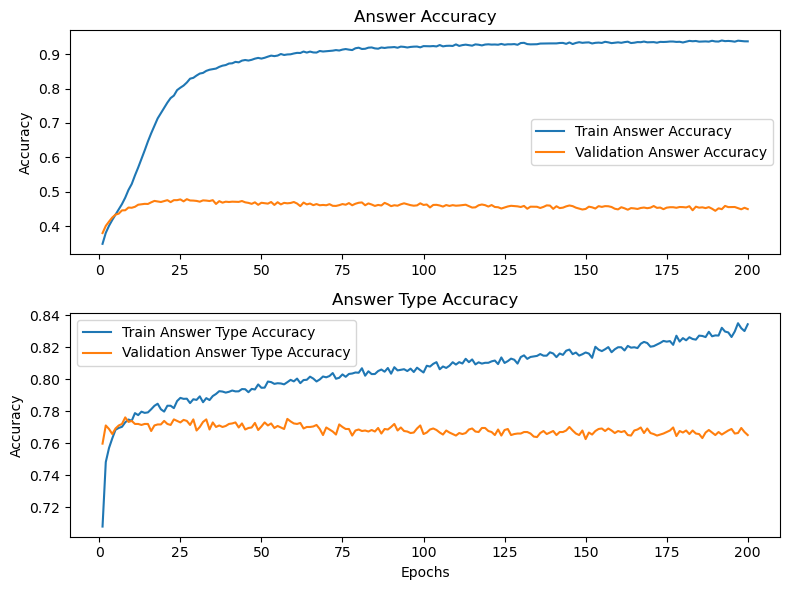

In [102]:
epochs = range(1,201)

# Creating a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.plot(epochs, train_accs_a, label='Train Answer Accuracy')
ax1.plot(epochs, val_accs_a, label='Validation Answer Accuracy')
ax2.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Answer Accuracy')
ax1.legend()

ax2.plot(epochs, train_accs_at, label='Train Answer Type Accuracy')
ax2.plot(epochs, val_accs_at, label='Validation Answer Type Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Answer Type Accuracy')
ax2.legend()

fig.tight_layout()

plt.show()

In [ ]:
idx = 700

answer, atype = model(X_val[idx])
print(lb_answers.classes_[torch.argmax(answer)])
print(lb_types.classes_[torch.argmax(atype)])
print('-------------------')
print(val_df[idx])

In [ ]:
display(IM(filename='/kaggle/input/vizwiz/data/Images/'+val_df[idx][0]))